In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import random

import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy.stats as stats
from scipy.stats import probplot, laplace, norm, t


import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

import pymc as pm
import arviz as az

from tensorflow import keras
#from tensorflow.keras.utils import plot_model


######################################
#from pmdarima import auto_arima
#from diptest import diptest

In [ ]:
class NoiseGenerator:
    def __init__(self, noise_type='gaussian', mu=0.0, sigma=1.0, s0=0, dt=1, seed=42):
        self.noise_type = noise_type
        self.mu = mu
        self.sigma = sigma
        self.s0 = s0
        self.dt = dt
        np.random.seed(seed)  # For reproducibility
        self.n = None

    def generate(self, n):
        self.n=n

        if self.noise_type == 'gaussian':
            return self._gaussian()
        elif self.noise_type == 'brownian':
            return self._brownian()
        elif self.noise_type == 'exponential_brownian':
            return self._exponential_brownian()
        else:
            raise ValueError("Invalid noise type. Choose from 'gaussian', 'brownian', or 'exponential_brownian'.")

    def _gaussian(self):
        """Generates Gaussian (normal) noise."""
        return np.random.normal(self.mu, self.sigma, self.n)

    def _brownian(self):
        """Generates Brownian motion (Wiener process)."""
        w = np.random.normal(self.mu, np.sqrt(self.dt), self.n).cumsum()
        return self.s0 + self.mu * np.arange(self.n) * self.dt + self.sigma * w

    def _exponential_brownian(self):
        """Generates Exponential Brownian Motion (Geometric Brownian Motion)."""
        w = np.random.normal(0, np.sqrt(self.dt), self.n).cumsum()
        time = np.linspace(0, self.n * self.dt, self.n)
        return self.s0 * np.exp((self.mu - 0.5 * self.sigma**2) * time + self.sigma * w)

In [ ]:
class prediction_analysis:

    def __init__(self, df, y_test_pred, nfuture):
        self.df = df
        self.y_pred = y_test_pred
        self.nfuture = nfuture

    def ml_ts_plot(self, y_total_pred, npast):
        df_plot = self.df.iloc[npast:].copy()
        df_plot['Predicted_Close'] = y_total_pred

        plt.figure(figsize=(12, 6))

        # --- Time Series Plot: Actual vs Predicted ---
        plt.plot(df_plot.index, df_plot['Close'], label='Actual Close', color='blue')
        plt.plot(df_plot.index, df_plot['Predicted_Close'], label='Predicted Close', linestyle='--', color='orange')

        split_time = self.df.iloc[-self.nfuture].name
        plt.axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

        plt.title('Actual vs Predicted Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        # Optional: limit x-axis
        # plt.xlim(self.df.index[-2 * self.nfuture], self.df.index[-1])

        plt.tight_layout()
        plt.show()


    def plot_predictions(self):
        df_plot = self.df.iloc[-self.nfuture:].copy()
        df_plot['Predicted_Close'] = self.y_pred

        # Calculate percentage error
        df_plot['Prediction_Change_%'] = 100 * (df_plot['Close'] - df_plot['Predicted_Close']) / df_plot['Close']
        df_plot.dropna(inplace=True)

        # Get predicted % changes
        test_preds = df_plot['Prediction_Change_%'].values
        x_vals = np.linspace(min(test_preds)-5, max(test_preds)+5, 1000)

        # Fit Student's t-distribution
        df_t, loc_t, scale_t = t.fit(test_preds)
        pdf_t = t.pdf(x_vals, df_t, loc=loc_t, scale=scale_t)
        ci_lower_t, ci_upper_t = t.interval(0.95, df_t, loc=loc_t, scale=scale_t)

        # Fit GMM
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(test_preds.reshape(-1, 1))
        gmm_means = gmm.means_.flatten()
        gmm_stds = np.sqrt(gmm.covariances_).flatten()
        gmm_weights = gmm.weights_.flatten()

        pdf_gmm = np.zeros_like(x_vals)
        for w, m, s in zip(gmm_weights, gmm_means, gmm_stds):
            pdf_gmm += w * (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - m) / s) ** 2)

        # Create subplots
        fig, axs = plt.subplots(nrows=2, figsize=(14, 10))
        fig.subplots_adjust(hspace=0.4)

        # --- Subplot 1: Error vs Actual ---
        axs[0].scatter(df_plot.index, df_plot['Prediction_Change_%'], alpha=0.6, color='green')
        axs[0].axhline(y=0, color='red', linestyle='--', label='No Error')
        split_time = self.df.iloc[-self.nfuture].name
        axs[0].axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

        axs[0].set_title('Percentage Prediction Error vs Actual Price')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Prediction_Change_%')
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_ylim(-20, 20)

        # --- Subplot 2: Histogram + Distribution Fits ---
        sns.histplot(test_preds, bins=30, kde=False, stat="density", color='gray', alpha=0.4, ax=axs[1], label='Histogram')

        # Student's t-distribution
        axs[1].plot(x_vals, pdf_t, color='green', label=f"Student's t PDF (df={df_t:.2f})")
        axs[1].axvline(loc_t, color='green', linestyle='--', label='t Mean')
        axs[1].axvline(ci_lower_t, color='green', linestyle='-.', label='t 95% CI')
        axs[1].axvline(ci_upper_t, color='green', linestyle='-.')

        # GMM PDF
        axs[1].plot(x_vals, pdf_gmm, label='GMM PDF (2 components)', color='purple')
        axs[1].axvline(gmm_means[0], color='purple', linestyle='--', label=f'GMM Mean 1: {gmm_means[0]:.2f}')
        axs[1].axvline(gmm_means[1], color='purple', linestyle='--', label=f'GMM Mean 2: {gmm_means[1]:.2f}')

        axs[1].set_title("Fit of Student’s t-Distribution and GMM to Predicted % Changes")
        axs[1].set_xlabel("Predicted Change (%)")
        axs[1].set_ylabel("Density")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Print optional info
        print(f"Student's t-distribution 95% CI: [{ci_lower_t:.2f}, {ci_upper_t:.2f}]")
        print(f"GMM means: {gmm_means}, std devs: {gmm_stds}")



In [ ]:
class SARIMAModel:
    def __init__(self, series):
        self.model = None
        self.series = series

    def fit_predict(self, df_org, nfuture, order, seasonal_order, ndiff, logg=True):
        df=self.series
        split_index = int(len(df) - nfuture)
        ts = df.iloc[:split_index]

        model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)
        result_sarima = model.fit()
        print (result_sarima.summary())

        ##ANALYSIS
        # Train sample fitted values & confidence intervals
        train_pred = result_sarima.get_prediction(start=0, end=split_index-1)
        train_values = train_pred.predicted_mean

        #Fittedvalues
        pred_values=train_values
        ts = ts.values

        # 1. Correlation between actual and fitted values
        correlation = np.corrcoef(ts, pred_values)[0, 1]
        print(f"Correlation (Actual vs. Fitted): {correlation:.4f}")

        # 2. Residuals analysis
        residuals = ts - pred_values

        # 2a. Q-Q Plot for normality check
        plt.figure(figsize=(6, 6))
        probplot(residuals, dist="norm", plot=plt)
        plt.title("Q-Q Plot of Residuals")
        plt.show()

        # 2b. Histogram of residuals
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=20, density=True, alpha=0.6, color='b')
        # Fit and plot KDE
        kde = KDEUnivariate(residuals)
        kde.fit()
        x_range = np.linspace(min(residuals), max(residuals), 100)
        plt.plot(x_range, kde.evaluate(x_range), color='red', label="KDE Fit")

        plt.title("Histogram and KDE of Residuals")
        plt.legend()
        plt.show()

        # 3. Ljung-Box Test (Autocorrelation in Residuals)
        # Perform Ljung-Box Test for multiple lags
        lags = np.arange(1, 21)  # Checking for first 20 lags
        ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=lags, return_df=True)

        # Extract p-values
        p_values = ljung_box_results['lb_pvalue']

        # Plot Ljung-Box p-values
        plt.figure(figsize=(10, 5))
        plt.stem(lags, p_values, basefmt=" ")
        plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
        plt.xlabel('Lag')
        plt.ylabel('p-value')
        plt.title('Ljung-Box Test P-values for Different Lags')
        plt.legend()
        plt.show()

        # 4. Error Metrics
        mae = np.mean(np.abs(residuals))
        mse = np.mean(residuals**2)
        rmse = np.sqrt(mse)

        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")


        #####################################################
        #forecast value

        # All sample fitted values & confidence intervals
        fitted_pred = result_sarima.get_prediction(start=0, end=len(df)-1)
        fitted_values = fitted_pred.predicted_mean
        fitted_conf_int = fitted_pred.conf_int()

        # Plot actual, fitted, and predicted values with confidence intervals
        plt.figure(figsize=(10, 5))

        # Plot observed data
        plt.plot(df, label="Actual", linestyle="dashed", alpha=0.7, color="blue")

        # Plot fitted values
        plt.plot(df.index, fitted_values, label="Fitted", color='red')

        # Confidence interval for fitted values
        plt.fill_between(df.index,
                        fitted_conf_int.iloc[:, 0],  # Lower bound
                        fitted_conf_int.iloc[:, 1],  # Upper bound
                        color="red", alpha=0.2, label="95% CI (Fitted)")

        plt.axvline(x=df.index[split_index], color='k', linestyle='--', label='Train/Test split')
        plt.title("SARIMA Model - Actual & Fitted & Forecast with Confidence Intervals")
        plt.legend()
        plt.show()

        ############################################
        #forecast value to original scale
        if logg:
            log_reverse_series = pd.Series(fitted_values[split_index:].cumsum() + np.log(df_org.iloc[split_index])) #diff order = 1
            ICI = np.exp(fitted_conf_int.iloc[split_index:, 0] + np.log(df_org.iloc[split_index]))
            FCI = np.exp(fitted_conf_int.iloc[split_index:, 1] + np.log(df_org.iloc[split_index]))
            reverse_series = np.exp(log_reverse_series).dropna()
        else:
            reverse_series = fitted_values[split_index-1:].cumsum() #diff order = 1
            ICI = (fitted_conf_int.iloc[split_index:, 0] + df_org.iloc[split_index])
            FCI = (fitted_conf_int.iloc[split_index:, 1] + df_org.iloc[split_index])

        # Plot actual vs. fitted values
        plt.figure(figsize=(10,5))
        plt.plot(df_org, label="Actual", linestyle="dashed", alpha=0.7)
        plt.plot(df_org.index[split_index+1:], reverse_series , label="Fitted", color='green')
        plt.axvline(x=df_org.index[split_index], color='k', linestyle='--', label='Train/Test split')

        # Confidence interval for fitted values
        plt.fill_between(df_org.index[split_index+1:],
                        ICI,  # Lower bound
                        FCI,  # Upper bound
                        color="red", alpha=0.2, label="95% CI (Fitted)")

        plt.title("SARIMA Model - Actual vs. Fitted Values")

        plt.legend()
        plt.show()

        return reverse_series


    def difference(self, ndiff, plot=True):
        diff = self.series.diff(ndiff)
        self.series = diff
        self.check_stationarity()
        return diff

    def log_difference(self, ndiff, plot=True):
        log_series = np.log(self.series).dropna()
        diff = log_series.diff(ndiff).dropna() if ndiff > 0 else log_series
        self.series = diff
        self.check_stationarity()
        return diff

    def check_stationarity(self, window=30, lags=30):
        # Rolling Mean & Standard Deviation
        rolling_mean = self.series.rolling(window=window).mean()
        rolling_std = self.series.rolling(window=window).std()

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(self.series, label="Original", color="gray", alpha=0.5)
        ax1.plot(rolling_mean, label="Rolling Mean", color="blue")
        ax1.axhline(y=0, color='black', linestyle='dashed', linewidth=0.8)
        ax1.legend(loc="upper left")

        ax2 = ax1.twinx()
        ax2.plot(rolling_std, label="Rolling Std Dev", color="red", linestyle="dashed", alpha=0.7)
        ax2.legend(loc="upper right")

        plt.title("Rolling Mean & Std Deviation")
        plt.show()

        # Augmented Dickey-Fuller Test
        adf_result = adfuller(self.series.dropna())
        print("ADF Test")
        print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
        print("Stationary" if adf_result[1] < 0.05 else "Not Stationary")

        # KPSS Test
        kpss_stat, kpss_p, _, crit = kpss(self.series.dropna(), regression='c')
        print("KPSS Test")
        print(f"KPSS Statistic: {kpss_stat:.4f}, p-value: {kpss_p:.4f}")
        print("Stationary" if kpss_p > 0.05 else "Not Stationary")

        # ACF and PACF
        plt.figure(figsize=(12, 5))
        plot_acf(self.series.dropna(), lags=lags)
        plt.title("Autocorrelation Function (ACF)")
        plt.show()

        plt.figure(figsize=(12, 5))
        plot_pacf(self.series.dropna(), lags=lags)
        plt.title("Partial Autocorrelation Function (PACF)")
        plt.show()

In [ ]:
class LSTMModel:
    def __init__(self, sequence_length):

        # Define model architecture
        inputs = keras.Input(shape=(sequence_length, 1 ))
        x = keras.layers.LSTM(252, return_sequences=True)(inputs)
        x = keras.layers.Dropout(0.3)(x)
        x = keras.layers.LSTM(252, return_sequences=True)(x)
        x = keras.layers.Dropout(0.3)(x)
        x = keras.layers.LSTM(252)(x)
        outputs = keras.layers.Dense(1, activation='relu')(x)

        # Compile model
        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='adam', loss="mse")
        self.model.summary()

    def train(self, X_train, y_train, columns, epochs=25, batch_size=32):
        x_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        self.model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split = 0.2)

    def predict(self, x_test):
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        return self.model.predict(x_test)

In [ ]:
class SimpleNNModel:
    def __init__(self, sequence_length):
        # Define model architecture
        inputs = keras.Input(shape=(sequence_length,))
        x = keras.layers.Dense(128, activation='relu')(inputs)
        x = keras.layers.Dense(64, activation='relu')(x)
        x = keras.layers.Dense(32, activation='relu')(x)
        outputs = keras.layers.Dense(1, activation='relu')(x)

        # Compile model
        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='adam', loss="mse")
        self.model.summary()

    def train(self, X_train, y_train, column, epochs=25, batch_size=32):
        # No reshaping needed for simple NN
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    def predict(self, x_test):
        return self.model.predict(x_test)

In [ ]:
class RandomForestModel:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)

    def train(self, x_train, y_train, columns):
        self.model.fit(x_train, y_train)

    def predict(self, x_test):
        return self.model.predict(x_test)

In [ ]:
class RidgeModel:
    def __init__(self):
        self.model = Ridge()

    def train(self, x_train, y_train, columns):
        self.model.fit(x_train, y_train)


        # Create summary DataFrame
        summary = pd.DataFrame({
            'Feature': columns,
            'Coefficient': self.model.coef_
        })
        plt.figure(figsize=(8, 4))
        plt.bar(summary['Feature'], summary['Coefficient'])
        plt.title('Feature Coefficients')
        plt.xlabel('Feature')
        plt.ylabel('Coefficient')
        plt.xticks(rotation=45)

        y_train_p = self.model.predict(x_train)
        # Metrics
        mse = mean_squared_error(y_train, y_train_p)                       # MSE: mean((y - ŷ)^2)
        rmse = np.sqrt(mse)                                                # RMSE: sqrt(MSE)
        mae = mean_absolute_error(y_train, y_train_p)                      # MAE: mean(|y - ŷ|)
        mape = mean_absolute_percentage_error(y_train, y_train_p) * 100    # MAPE: mean(|(y - ŷ)/y|) * 100
        r2 = r2_score(y_train, y_train_p)                                  # R2: 1 - (MSE / variance(y))

        print("Training Metrics:")
        print(f"  - MSE  = {mse:.4f}")
        print(f"  - RMSE = {rmse:.4f}")
        print(f"  - MAE  = {mae:.4f}")
        print(f"  - MAPE = {mape:.2f}%")
        print(f"  - R2 score = {r2:.2f}%")


    def predict(self, x_test):
        return self.model.predict(x_test)

In [ ]:
class features_ml:

    def __init__(self, df, npast, column, param = 252, split_type='index'):
        self.df = df.copy()
        self.npast = npast
        self.split_type = split_type
        self.param = param
        self.column=column
        self.X=None
        self.Y=None

    def features(self):
        self.df["date"] = self.df.index
        self.df["year"] = self.df["date"].dt.year
        self.df["month"] = self.df["date"].dt.month
        #self.df["day"] = self.df["date"].dt.day
        #self.df['day_of_year'] = self.df["date"].dt.dayofyear
        self.df.drop(columns=["date"], inplace=True)

        self.df['Noise'] = np.random.normal(0,1, self.df.shape[0])

        for lag in range(1, self.npast + 1):
            self.df[f'lag{lag}'] = self.df[self.column].shift(lag)

        self.df.dropna(inplace=True)

        self.y = self.df[self.column].copy()
        self.X = self.df.drop(columns=self.column).copy()
        self.X.info()
        return self.X, self.y

In [ ]:
class FutureDataPoint:
    def __init__(self, X_train_last, y_train_pred_npast , model, scaler, npast, column):
        self.X_new = X_train_last.copy()
        self.y_train_pred_npast = y_train_pred_npast.copy()
        self.model = model
        self.scaler = scaler
        self.npast = npast
        self.column = column

    def predict_future_steps(self, nfuture):
        y_test_pred = []
        for i in range(nfuture):

            next_index = self.X_new.index[0] + pd.tseries.offsets.BDay(1) # Set the next business day as the index
            self.X_new.index = [next_index]

            y_next = self.generate_datapoint_predict()
            y_test_pred.append(y_next)

        return np.array(y_test_pred)

    def generate_datapoint_predict(self):
        self.X_new["date"] = self.X_new.index
        self.X_new["year"] = self.X_new["date"].dt.year
        self.X_new["month"] = self.X_new["date"].dt.month
        #self.X_new["day"] = self.X_new["date"].dt.day
        #self.X_new["day_of_year"] = self.X_new["date"].dt.dayofyear
        self.X_new.drop(columns=["date"], inplace=True)

        # Add noise to the dataset
        self.X_new['Noise'] = np.random.normal(0, 1, 1)

        #add lags from predictions
        for i in range(1, self.npast+1):
            self.X_new[f'lag{i}'] = self.y_train_pred_npast[-i]
        self.X_new.dropna(inplace=True)

        # Scale the new data point
        X_new_scaled = self.scaler.transform(self.X_new)

        # Predict next value
        y_next = self.model.predict(X_new_scaled)

        for i in range(0,self.npast-1):
          self.y_train_pred_npast[i+1] = self.y_train_pred_npast[i]
        self.y_train_pred_npast[0] = y_next.flatten()[0]

        return y_next

In [ ]:
class Bayesian_PP:
    def __init__(self):
        self.log_returns = None
        self.df=None

        self.mu_prior = None
        self.sigma_prior = None
        self.mu_j_prior = None
        self.sigma_j_prior = None
        self.lamda_j_prior = None

        self.mu_samples = None
        self.sigma_samples = None
        self.mu_j_samples = None
        self.sigma_j_samples = None
        self.lamda_j_samples = None

    def log_return(self, df):
        self.df=df
        df['log_return'] = np.log(self.df / self.df.shift(1))
        self.log_returns = df['log_return'].dropna()

        '''GBM'''

        sorted = self.log_returns.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 1.5 * iqr
        upper_bound = qv2 + 1.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        log_returns_values = filtered_sorted.values

        mu, sigma = stats.norm.fit(log_returns_values)

        # Compute annualized values
        mu_annual = mu * 252
        sigma_annual = sigma * np.sqrt(252)

        mu_daily_rounded, sigma_daily_rounded, mu_annual_rounded, sigma_annual_rounded  = round(mu * 100, 2), round(sigma * 100, 2), round(mu_annual * 100, 2), round(sigma_annual * 100, 2)
        print(f"Daily mu (sigma) = {mu_daily_rounded}% ± {sigma_daily_rounded}%")
        print(f"Annual mu (sigma) = {mu_annual_rounded}% ± {sigma_annual_rounded}%")

        # Setup subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

        # ─────────────────────────────
        # 1️⃣ Time Series Plot
        axs[0].plot(self.log_returns, label='Log Returns')
        axs[0].axhline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[0].axhline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[0].set_title('Daily Log Returns (Time Series)', fontsize=14)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Log Return')
        axs[0].legend()
        axs[0].grid(True)

        # ─────────────────────────────
        # 2️⃣ Histogram + Gaussian Fit
        x = np.linspace(self.log_returns.min(), self.log_returns.max(), 1000)
        pdf = stats.norm.pdf(x, mu, sigma)

        axs[1].hist(log_returns_values, bins=50, density=True, alpha=0.6, edgecolor='k', label='Histogram')
        axs[1].plot(x, pdf, 'r-', label=f'Gaussian Fit\nμ={mu:.4f}, σ={sigma:.4f}')
        axs[1].axvline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[1].axvline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[1].set_title('Log Returns Distribution & Gaussian Fit', fontsize=14)
        axs[1].set_xlabel('Log Return')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].grid(True)

        # ─────────────────────────────
        # 3️⃣ Q-Q Plot
        stats.probplot(log_returns_values, dist="norm", plot=axs[2])
        axs[2].get_lines()[1].set_color('red')  # Line of best fit
        axs[2].set_title('Q-Q Plot of Log Returns', fontsize=14)
        axs[2].grid(True)

        # Show all
        plt.show()

        self.mu_prior = mu
        self.sigma_prior = sigma

        ''' Merton'''

        threshold = 3 * sigma
        #Create binary jump indicator
        jump_indicator = (np.abs(self.log_returns - mu) > threshold).astype(int)

        #Resample by year and count jumps
        yearly_jump_counts = jump_indicator.resample('YE').sum()
        yearly_jump_counts.index = yearly_jump_counts.index.year

        sorted = yearly_jump_counts.sort_index()

        #Estimate λ (Poisson mean)
        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.0)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 0 * iqr
        upper_bound = qv2 + 0 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        yearly_jump_counts_values = filtered_sorted.values

        lambda_j = yearly_jump_counts_values.mean()

        ###
        # Theoretical quantiles from Poisson
        n = len(yearly_jump_counts_values)
        quantiles = np.linspace(0.01, 0.99, n)
        percentiles = np.quantile(yearly_jump_counts_values, quantiles)
        theoretical_q = stats.poisson.ppf(quantiles, mu=lambda_j)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # --- Plot 1: Histogram with Poisson PMF ---
        axs[0].hist(yearly_jump_counts_values, bins=range(int(max(yearly_jump_counts_values))+2),
                    density=True, alpha=0.6, edgecolor='k', label='Observed')

        x = np.arange(0, max(yearly_jump_counts_values)+1)
        pmf = stats.poisson.pmf(x, mu=lambda_j)
        axs[0].plot(x, pmf, 'ro-', label=f'Poisson PMF (λ={lambda_j:.2f})')

        axs[0].set_title("Poisson Fit to Yearly Jump Counts")
        axs[0].set_xlabel("Jump Count per Year")
        axs[0].set_ylabel("Probability")
        axs[0].legend()
        axs[0].grid(True)

        # --- Plot 2: Q-Q Plot ---
        axs[1].plot(theoretical_q, percentiles, 'bo', label='Empirical vs Poisson')
        axs[1].plot([0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    [0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    'r--', label='Ideal Fit (y = x)')

        axs[1].set_title("Q-Q Plot: Empirical vs Poisson Quantiles")
        axs[1].set_xlabel("Theoretical Quantiles (Poisson)")
        axs[1].set_ylabel("Empirical Quantiles (Observed)")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Estimate mu_J and sigma_J (jump size stats)
        jump_sizes = self.log_returns.loc[np.abs(self.log_returns - mu) > threshold].dropna() #Extract jump sizes

        sorted = jump_sizes.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 2.5 * iqr
        upper_bound = qv2 + 2.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        jump_sizes_values = filtered_sorted.values

        # Fit normal distribution
        mu_J, sigma_J = norm.fit(jump_sizes_values)

        # Create subplots: 1 row, 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Histogram with fitted normal curve
        axs[0].hist(jump_sizes_values, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        xmin, xmax = axs[0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_J, sigma_J)
        axs[0].plot(x, p, 'r', linewidth=2)
        axs[0].set_title("Histogram of Jump Sizes with Fitted Normal Curve")
        axs[0].set_xlabel("Jump Size")
        axs[0].set_ylabel("Density")
        axs[0].grid(True)
        # Add mu_J and sigma_J to the plot
        textstr = f"$\\mu_J$ = {mu_J:.4f}\n$\\sigma_J$ = {sigma_J:.4f}"
        axs[0].text(0.95, 0.95, textstr,
                    transform=axs[0].transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.8))

        # Q-Q plot
        probplot(jump_sizes_values, dist="norm", sparams=(mu_J, sigma_J), plot=axs[1])
        axs[1].set_title("Q-Q Plot vs Fitted Normal")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        self.mu_j_prior = mu_J
        self.sigma_j_prior = sigma_J
        self.lamda_j_prior = lambda_j

        return self.mu_prior, self.sigma_prior, self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior


    """Fit a Bayesian model to estimate mu and sigma."""
    def fit_bayesian_model(self, nsample, nburn, nchain):

        with pm.Model() as model:

            # Prior for mu
            mu = pm.Normal("mu", mu=self.mu_prior, sigma=self.sigma_prior)

            #Prior for sigma
            #sigma_squared = pm.InverseGamma("sigma_squared", alpha=2, beta=self.sigma_prior)
            #igma = pm.Deterministic("sigma", pm.math.sqrt(sigma_squared))

            sigma = pm.HalfNormal("sigma", sigma=self.sigma_prior)

            # Likelihood (observed log returns)
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.log_returns)

            # Sampling (using Metropolis algorithm)
            step = pm.Metropolis()
            trace = pm.sample(nsample+nburn, step=step, tune=nburn, chains=nchain, return_inferencedata=True, random_seed=42)

        az.plot_trace(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        az.plot_autocorr(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        summary = az.summary(trace, var_names=["mu", "sigma"], round_to=4)
        print(summary)

        # Extract posterior samples
        self.mu_samples = trace.posterior['mu'].values.flatten()
        self.sigma_samples = trace.posterior['sigma'].values.flatten()

        return self.mu_samples, self.sigma_samples



In [ ]:
class Stochastic_prices_bayesian:
    def __init__(self, df, nfuture, last_price ,npath, mu_samples, sigma_samples, mu_j_samples, sigma_j_samples, lambda_j_samples, rfr, risk_neutral = True):
        self.nfuture = nfuture
        self.df = df
        self.rfr = rfr
        self.risk_neutral = risk_neutral
        self.npath = npath
        self.last_price = last_price
        self.simulated_prices = None

        self.mu_samples = mu_samples
        self.sigma_samples = sigma_samples
        self.mu_j_samples = mu_j_samples
        self.sigma_j_samples = sigma_j_samples
        self.lamda_j_samples = lambda_j_samples

        self.forced_loop = 2


    def simulate_future_prices_Merton(self):
        simulated_prices = np.zeros((self.forced_loop, self.npath, self.nfuture + 1))

        simulated_prices[: , :, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        # Simulate using each posterior sample
        for iii in range(self.forced_loop):
            mu_sample = self.mu_samples[iii]
            sigma_sample = self.sigma_samples[iii]
            mu_j_sample = self.mu_j_samples[0]
            sigma_j_sample = self.sigma_j_samples[0]
            lamda_j_year = self.lamda_j_samples[0]
            lamda_j_sample = lamda_j_year * dt

            for ii in range(self.npath):
                    for t in range(1, self.nfuture + 1):
                        #Semi-analytical solution
                        z = np.random.normal(0, 1, 1)
                        NN = np.random.poisson(lam=lamda_j_sample, size=1)[0]
                        J_NN=np.random.normal(mu_j_sample, sigma_j_sample, NN)

                        first_term = -lamda_j_sample * (np.exp(mu_j_sample + 0.5 * sigma_j_sample**2) -1) *dt
                        second_term = np.sum(J_NN)

                        if self.risk_neutral:
                            jump_term = (first_term + second_term)
                            simulated_prices[iii,ii, t] = simulated_prices[iii,ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)
                        else:
                            jump_term =  second_term
                            simulated_prices[iii,ii, t] = simulated_prices[iii,ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)

            self.simulated_prices = np.mean(simulated_prices, axis=0)
        return self.simulated_prices

    def simulate_future_prices_GBM(self):
        simulated_prices = np.zeros((self.forced_loop, self.npath, self.nfuture + 1))

        simulated_prices[: , :, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        # Simulate using each posterior sample
        for iii in range(self.forced_loop):
            mu_sample = self.mu_samples[iii]
            sigma_sample = self.sigma_samples[iii]

            for ii in range(self.npath):
                    for t in range(1, self.nfuture + 1):
                        #Semi-analytical solution
                        z = np.random.normal(0, 1, 1)

                        if self.risk_neutral:
                            simulated_prices[iii,ii, t] = simulated_prices[iii,ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
                        else:
                            simulated_prices[iii,ii, t] = simulated_prices[iii,ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
            self.simulated_prices = np.mean(simulated_prices, axis=0)
        return self.simulated_prices


    def simulate_future_prices_btree(self):
        simulated_prices = np.zeros((self.forced_loop, self.npath, self.nfuture + 1))

        simulated_prices[:,:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        # Simulate using each posterior sample
        for iii in range(self.forced_loop):
            mu_sample = self.mu_samples[iii]
            sigma_sample = self.sigma_samples[iii]
            u = np.exp(self.sigma_samples[iii] * np.sqrt(dt))
            d = 1 / u
            for ii in range(self.npath):
                    for t in range(1, self.nfuture + 1):
                        #Analytical solution COX-Ross-Rubinstein model
                        ur = np.random.rand()

                        if self.risk_neutral:
                            p = (np.exp(self.rfr * dt) - d) / (u - d)
                            move = ur < p  # True = up, False = down
                            simulated_prices[iii, ii, t] = simulated_prices[iii, ii, t - 1] * (u if move else d)
                        else:
                            p = (np.exp(mu_sample * dt) - d) / (u - d)
                            move = ur < p  # True = up, False = down
                            simulated_prices[iii, ii, t] = simulated_prices[iii, ii, t - 1] * (u if move else d)

        self.simulated_prices = np.mean(simulated_prices, axis=0)
        return self.simulated_prices

    def plot_monte_carlo(self, simulated_prices, split_index):
        print ("Today's value = ", self.df.iloc[-1])

        plt.figure(figsize=(12, 6))
        plt.plot(self.df[:], color='black', alpha=1, label="Historical Price")

        std_path = np.std(simulated_prices, axis=0)
        mean_path = np.mean(simulated_prices, axis=0)

        plt.plot(self.df.index[split_index-1:], mean_path, color='blue', alpha=1, label="Mean Forecast")
        plt.fill_between(self.df.index[split_index-1:], mean_path - std_path, mean_path + std_path,
                     color='orange', alpha=0.2, label="±1 Std Dev")
        plt.axvline(x=self.df.index[split_index], color='k', linestyle='--', label='Train/Test split')

        plt.title(f"Simulated Future Stock Prices (Bayesian GBM)")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

        final_prices = simulated_prices[:, -1]
        mu_final = np.mean(final_prices)
        std_final = np.std(final_prices)
        ci_lower, ci_upper = np.percentile(final_prices, [2.5, 97.5])

        plt.figure(figsize=(10, 5))

        # Histogram
        sns.histplot(final_prices, bins=50, kde=False, stat="density", color="skyblue", edgecolor="gray", label="Simulated Final Prices")

        # Fit and plot Gaussian
        x_vals = np.linspace(final_prices.min(), final_prices.max(), 200)
        pdf_vals = stats.norm.pdf(x_vals, mu_final, std_final)
        plt.plot(x_vals, pdf_vals, color='red', lw=2, label="Fitted Normal")

        # Mean line
        plt.axvline(mu_final, color='black', linestyle='--', label=f"Mean = {mu_final:.2f}")

        # ±1 Std Dev
        plt.axvspan(mu_final - std_final, mu_final + std_final, color='orange', alpha=0.2, label=f"±1 Std Dev")

        # 95% CI
        plt.axvline(ci_lower, color='blue', linestyle='--', alpha=0.8, label=f"95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")
        plt.axvline(ci_upper, color='blue', linestyle='--', alpha=0.8)

        plt.title("Distribution of Simulated Final Stock Prices")
        plt.xlabel("Final Price")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
class StockData:
    def __init__(self, ticker, start, end, column):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.df = None
        self.column=column

    def fetch_data(self):
        self.df = yf.download(self.ticker, start=self.start, end=self.end)

        self.df = self.df.sort_index()
        self.df = self.df.dropna()
        self.df.info()

        #PLOT
        ax = self.df.drop(columns=["Volume"]).plot(figsize=(12, 6), title=self.ticker + "Stock Prices")
        ax.set_ylabel("Stock Price")
        ax2 = ax.twinx()
        ax2.set_ylabel("Volume")
        ax2.plot(self.df.index, self.df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
        ax2.legend(loc="upper left")
        plt.show()

        self.df.columns = self.df.columns.get_level_values(0)
        new_df = self.df[[self.column]].copy()
        new_df.info()

        self.CAGR(new_df)
        return new_df

    #change to OOP later
    def CAGR(self, df):
        # Ensure the DataFrame index is datetime
        df = df.sort_index()
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index must be a DatetimeIndex.")

        yearly_cagr = {}
        cumulative_cagr = {}

        years = sorted(df.index.year.unique())

        # Use the second year as the start to avoid incomplete initial data
        start_year = years[0]
        start_date = df[df.index.year == start_year].index[0]
        start_value = df.loc[start_date].values[0]

        for year in years:  # Skip the first year
            # Yearly CAGR
            yearly_df = df[df.index.year == year]
            start = yearly_df.iloc[0].values[0]
            end = yearly_df.iloc[-1].values[0]
            days = (yearly_df.index[-1] - yearly_df.index[0]).days
            if days > 0:
                yearly_cagr[year] = (end / start) ** (365.25 / days) - 1

            # Cumulative CAGR from start_year to current year
            end_value = df[df.index.year <= year].iloc[-1].values[0]
            total_days = (df[df.index.year <= year].index[-1] - start_date).days
            if total_days > 0:
                cumulative_cagr[year] = (end_value / start_value) ** (365.25 / total_days) - 1

        # Plot
        plt.figure(figsize=(12, 6))

        # Yearly CAGR line
        plt.plot(yearly_cagr.keys(), [v * 100 for v in yearly_cagr.values()],
                marker='o', label='Yearly CAGR')

        # Cumulative CAGR line
        cumulative_values = [v * 100 for v in cumulative_cagr.values()]
        plt.plot(cumulative_cagr.keys(), cumulative_values,
                marker='s', linestyle='--', label='Cumulative CAGR')

        # Annotate cumulative CAGR values
        for year, val in cumulative_cagr.items():
            plt.text(year, val * 100 + 0.5, f"{val * 100:.2f}%", ha='center', fontsize=8, color='blue')

        plt.axhline(0, color='black', linewidth=0.5)
        plt.title("Yearly vs Cumulative CAGR of NIFTY Close Prices")
        plt.xlabel("Year")
        plt.ylabel("CAGR (%)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
class StockPredictor:
    def __init__(self, ticker, start, end, column, nfuture = 252):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.model_type = None
        self.df=None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.nfuture = nfuture
        self.column=column
        self.rfr = 0.07
        self.risk_neutral = False

    def data_initiation(self):
        self.df = StockData(self.ticker, self.start, self.end, self.column).fetch_data()

    def run_ml(self, npast, model_type):

        if model_type == 'RidgeModel':
            self.model = RidgeModel()
        elif model_type == 'RandomForestModel':
            self.model = RandomForestModel()
        elif model_type == 'SimpleNNModel':
            self.model = SimpleNNModel(sequence_length=self.npast + 3)
        elif model_type == 'LSTMModel':
            self.model = LSTMModel(sequence_length=self.npast + 3)
        elif model_type == 'SARIMAModel':
            self.model = SARIMAModel()
        else:
            raise ValueError("Unsupported model type")


        #prepare features
        X, y = features_ml(self.df, npast, self.column, param = self.nfuture, split_type='index').features()

        #test-train data :ML
        split_index = int(X.shape[0] - self.nfuture)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        #train
        X_train_scaled = self.scaler.fit_transform(X_train)
        self.model.train(X_train_scaled, y_train, list(X.columns))

        #predict
        y_train_pred = self.model.predict(X_train_scaled)
        y_test_pred = FutureDataPoint(X_train.iloc[[-1]], y_train_pred[-npast:] , self.model, self.scaler, npast, self.column).predict_future_steps(self.nfuture)

        #analysis
        y_pred=np.concatenate((y_train_pred.flatten(), y_test_pred.flatten()))
        prediction_analysis(self.df, y_pred.flatten(), self.nfuture).ml_ts_plot(y_pred, npast)
        prediction_analysis(self.df, y_test_pred.flatten(), self.nfuture).plot_predictions()


    def run_ts(self, order, seasonal_order, model_type):
        if model_type == 'SARIMAModel':
            self.model = SARIMAModel(self.df[self.column])

        #preprocess_data and check check_stationarity
        log_diff_df = self.model.log_difference(ndiff=1)

        #fit and forecast
        y_test_pred = self.model.fit_predict(self.df[self.column], self.nfuture, order, seasonal_order, ndiff=1, logg=True)
        prediction_analysis(self.df, y_test_pred.values, self.nfuture).plot_predictions()

    def run_mcmc(self, nsample, nburn, nchain, model_type):
        #use bayesian posterior of mu and sigma
        bayesian = Bayesian_PP()
        mu_prior, sigma_prior, mu_j_prior, sigma_j_prior, lamda_j_prior = bayesian.log_return(self.df[self.column].iloc[:-self.nfuture])

        mu_samples, sigma_samples = bayesian.fit_bayesian_model(nsample, nburn, nchain)
        mu_j_samples, sigma_j_samples, lambda_j_samples = np.array([mu_j_prior]).flatten(), np.array([sigma_j_prior]).flatten(), np.array([lamda_j_prior]).flatten()

        self.model = Stochastic_prices_bayesian(self.df[self.column], self.nfuture, self.df[self.column].iloc[-self.nfuture], nsample, mu_samples, sigma_samples,  mu_j_samples, sigma_j_samples, lambda_j_samples, self.rfr, self.risk_neutral)

        if model_type == 'GBM':
            simulated_prices = self.model.simulate_future_prices_GBM()
        elif model_type == 'Merton':
            simulated_prices = self.model.simulate_future_prices_Merton()
        elif model_type == 'BinomialTree':
            simulated_prices = self.model.simulate_future_prices_btree()

        self.model.plot_monte_carlo(simulated_prices, len(self.df) - self.nfuture)
        mean_path = np.mean(simulated_prices, axis=0)
        prediction_analysis(self.df, mean_path.flatten()[1:], self.nfuture).plot_predictions()



[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2772 entries, 2014-01-02 to 2025-04-21
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   2772 non-null   float64
 1   (High, ^NSEI)    2772 non-null   float64
 2   (Low, ^NSEI)     2772 non-null   float64
 3   (Open, ^NSEI)    2772 non-null   float64
 4   (Volume, ^NSEI)  2772 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 129.9 KB


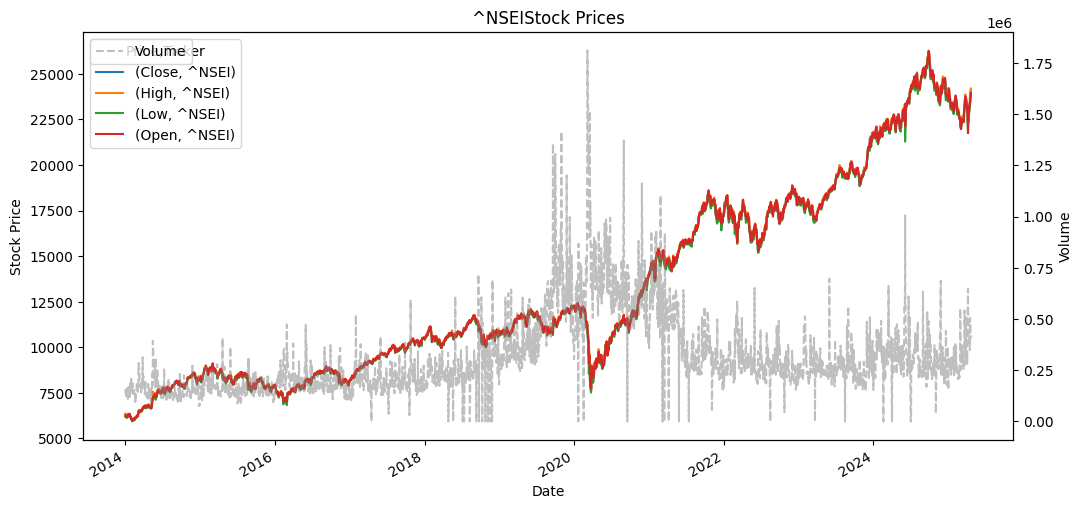

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2772 entries, 2014-01-02 to 2025-04-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2772 non-null   float64
dtypes: float64(1)
memory usage: 43.3 KB


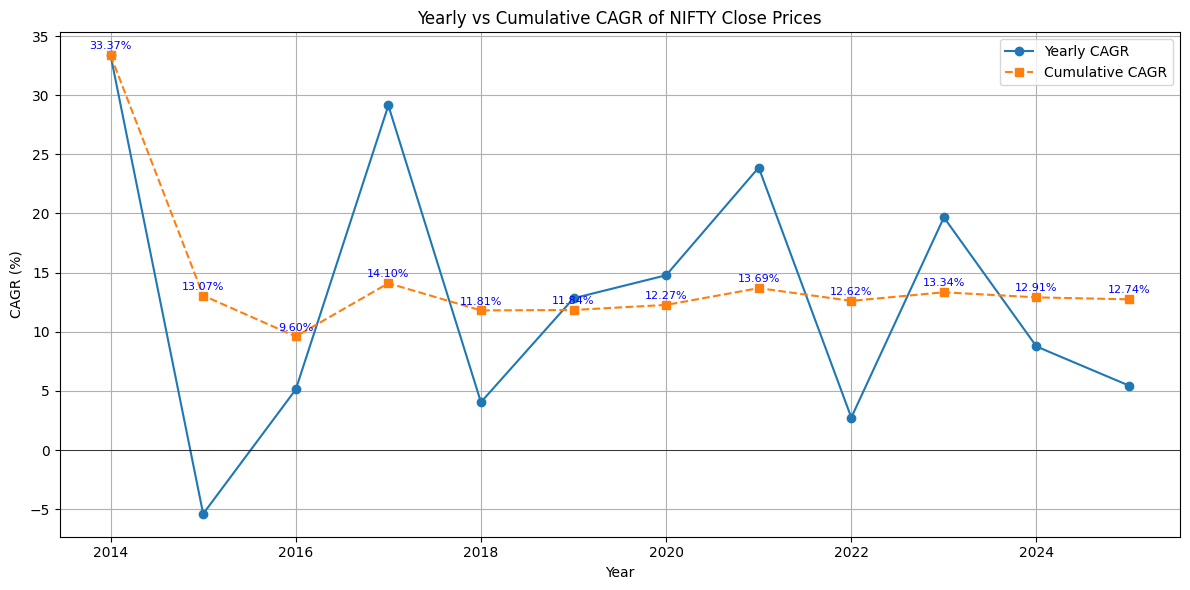

In [ ]:
predictor = StockPredictor('^NSEI', '2014-01-01', date.today(), 'Close', nfuture = 252)
predictor.data_initiation()

Daily mu (sigma) = 0.09% ± 0.76%
Annual mu (sigma) = 22.39% ± 12.12%


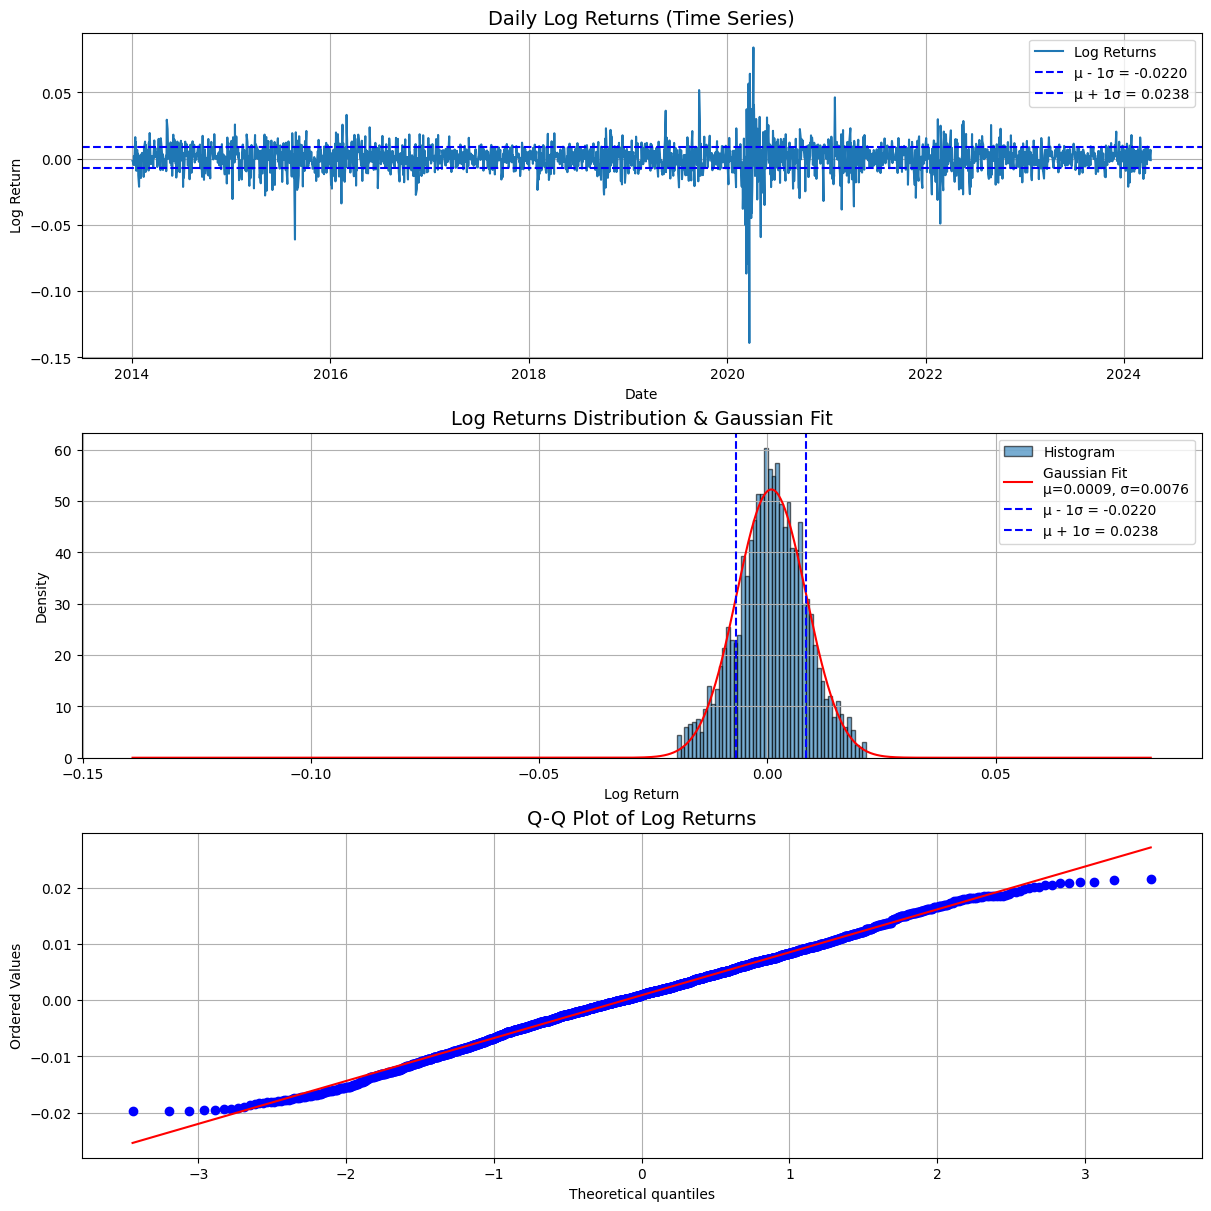

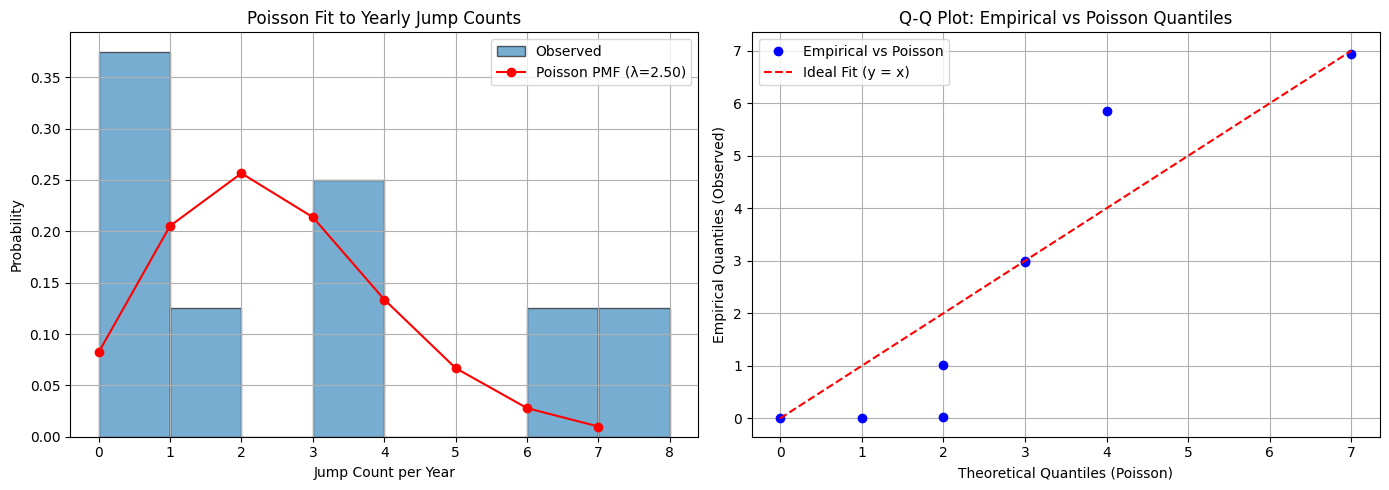

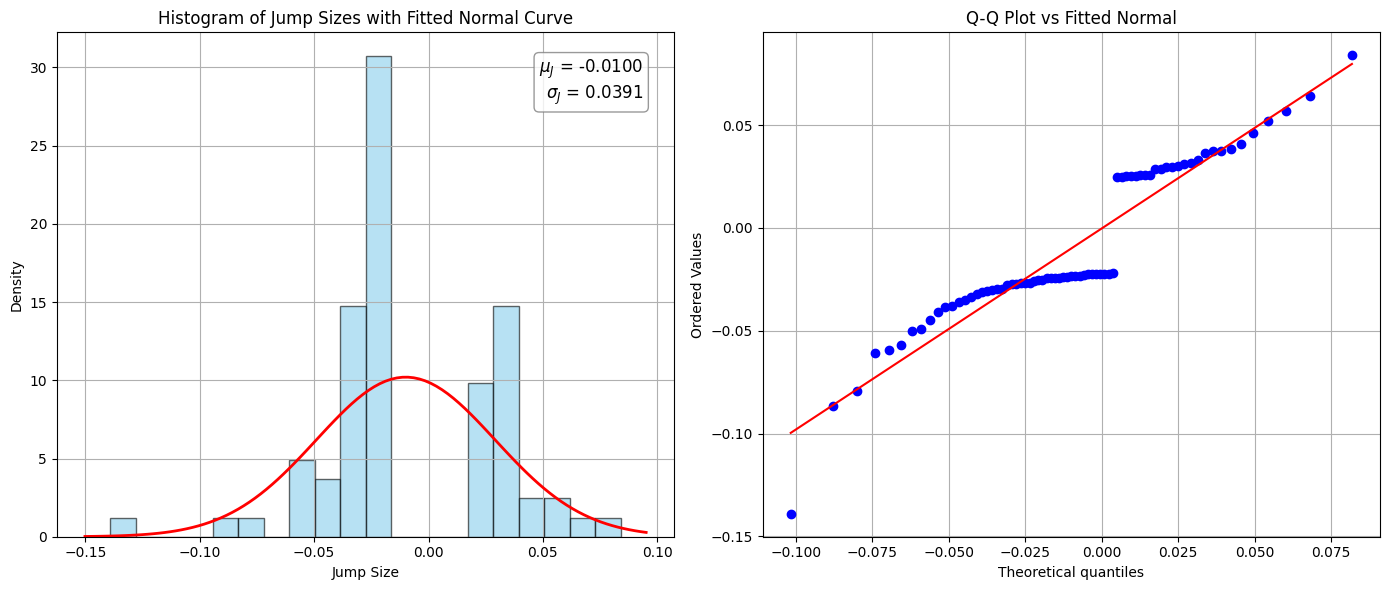

Output()

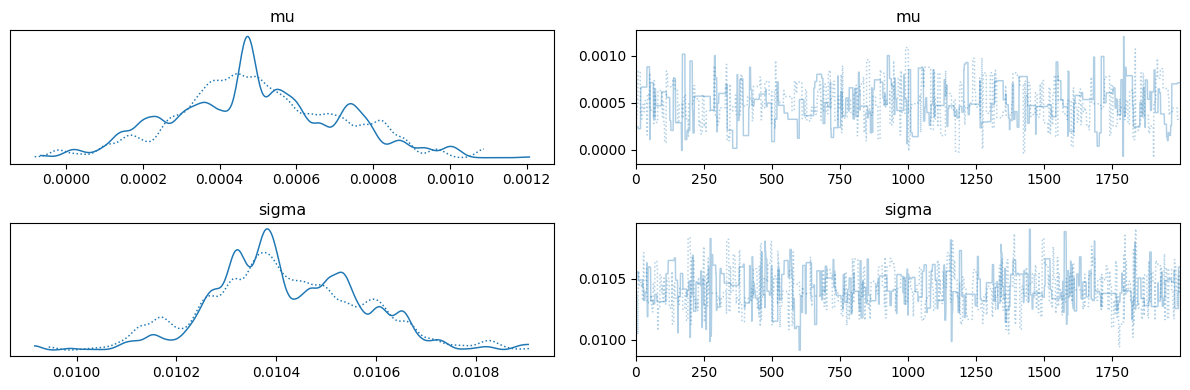

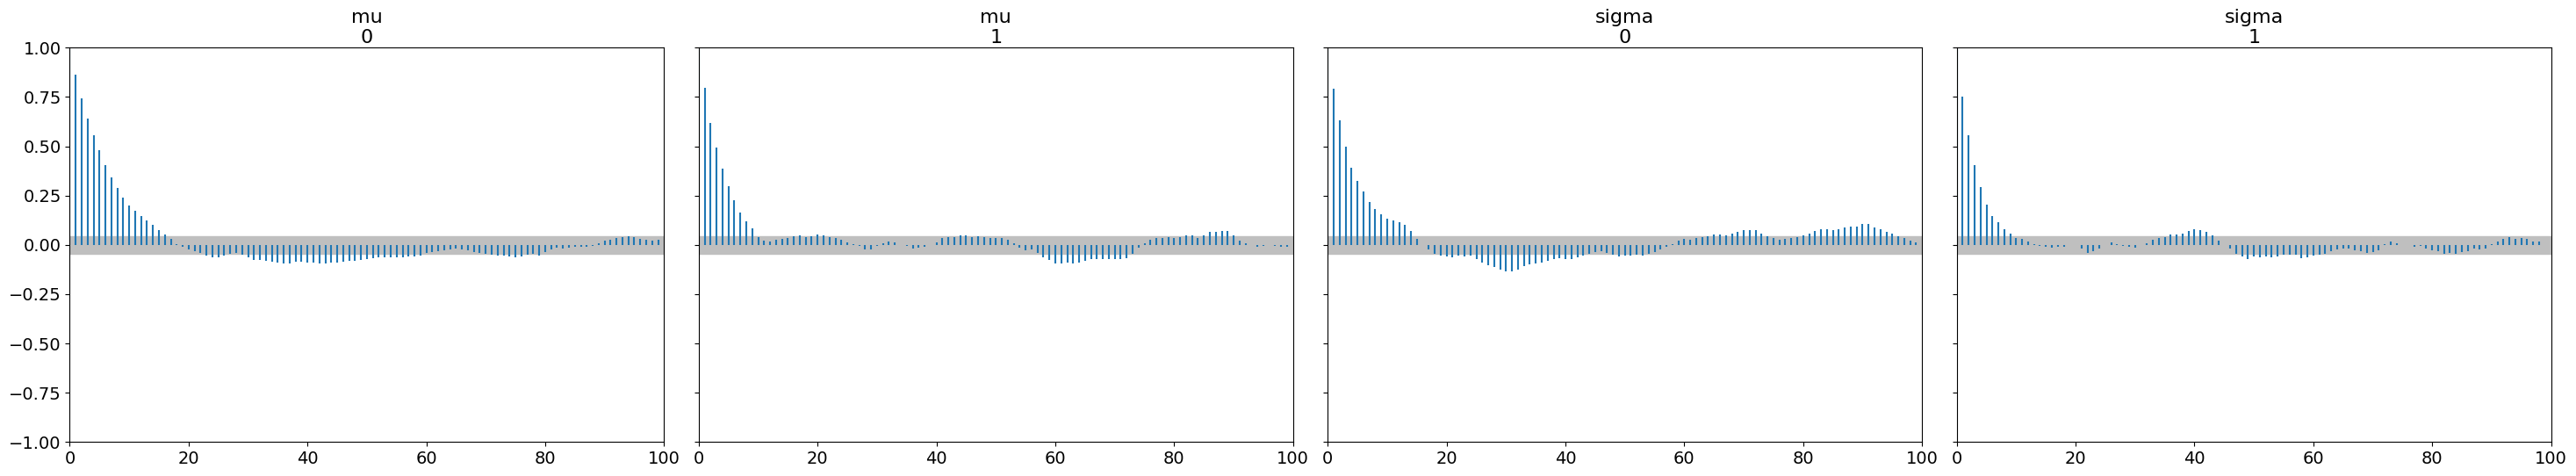

         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.0005  0.0002  0.0001   0.0009        0.0      0.0  398.2570   
sigma  0.0104  0.0002  0.0101   0.0107        0.0      0.0  532.6158   

       ess_tail   r_hat  
mu     354.3019  1.0042  
sigma  400.7918  1.0072  


<ipython-input-167-c2890e360abb>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_prices[iii,ii, t] = simulated_prices[iii,ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)


Today's value =  24125.55078125


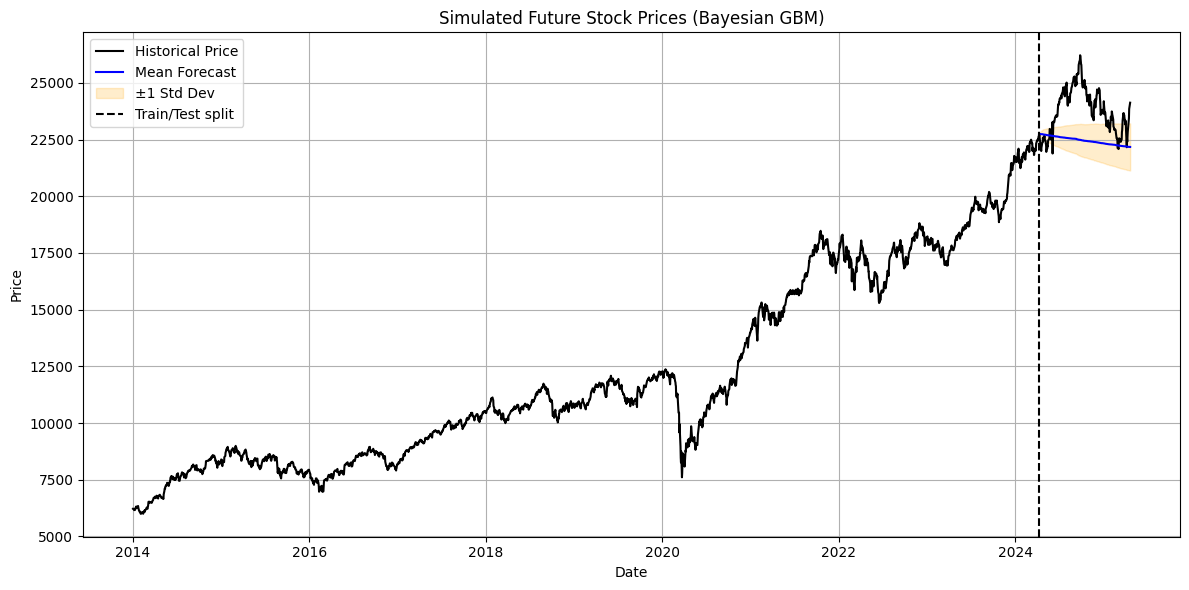

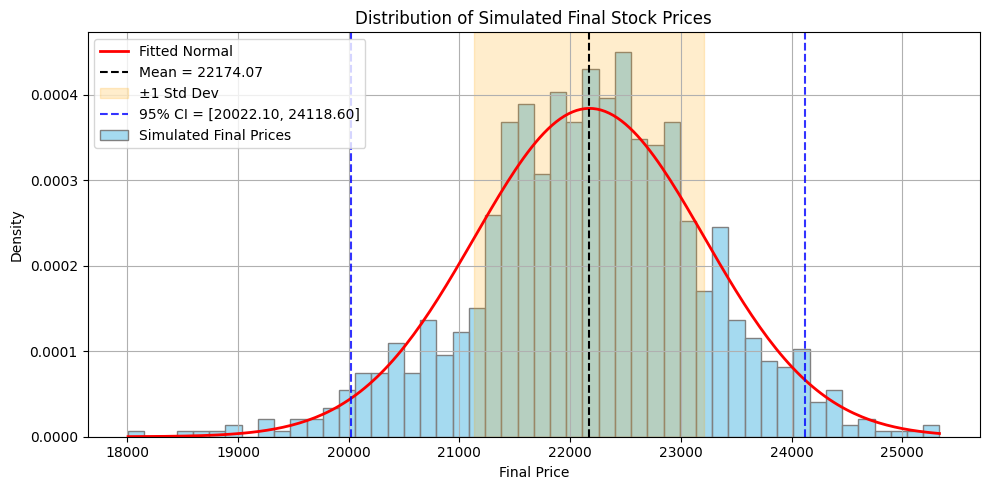

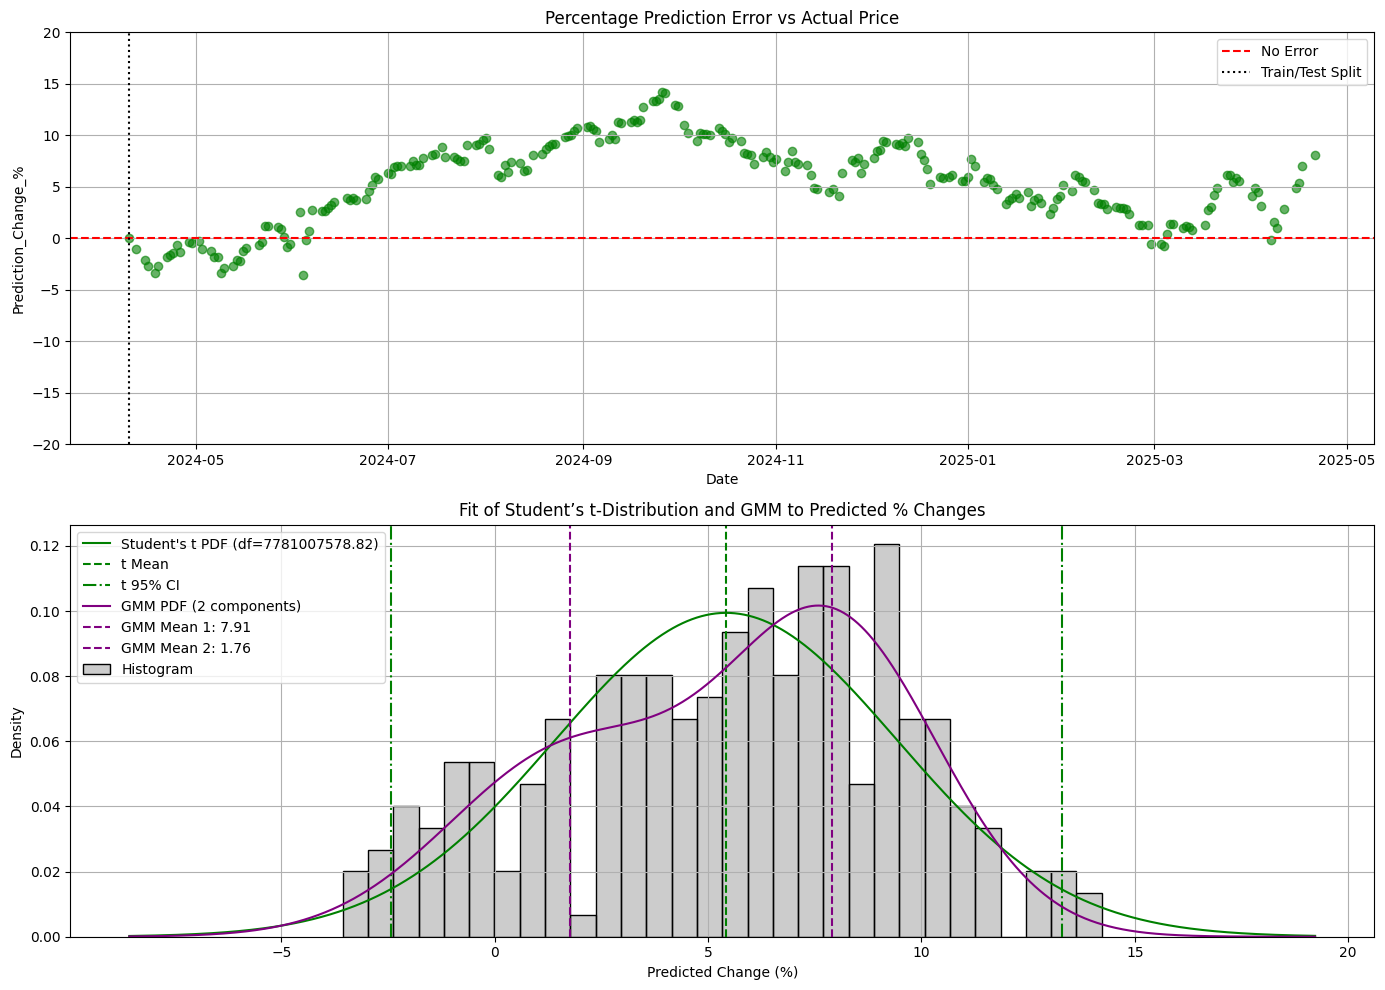

Student's t-distribution 95% CI: [-2.44, 13.28]
GMM means: [7.91277148 1.76044451], std devs: [2.4866554  2.85219649]


In [ ]:
sd_models = ['GBM', 'Merton', 'BinomialTree']
#no. of sample for bayesian and no of path for MCMC are kept same
predictor.run_mcmc(nsample=1000, nburn=1000, nchain=2, model_type='Merton')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2762 entries, 2014-01-16 to 2025-04-21
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    2762 non-null   int32  
 1   month   2762 non-null   int32  
 2   Noise   2762 non-null   float64
 3   lag1    2762 non-null   float64
 4   lag2    2762 non-null   float64
 5   lag3    2762 non-null   float64
 6   lag4    2762 non-null   float64
 7   lag5    2762 non-null   float64
 8   lag6    2762 non-null   float64
 9   lag7    2762 non-null   float64
 10  lag8    2762 non-null   float64
 11  lag9    2762 non-null   float64
 12  lag10   2762 non-null   float64
dtypes: float64(11), int32(2)
memory usage: 280.5 KB
Training Metrics:
  - MSE  = 28752.1423
  - RMSE = 169.5646
  - MAE  = 120.9396
  - MAPE = 1.03%
  - R2 score = 1.00%


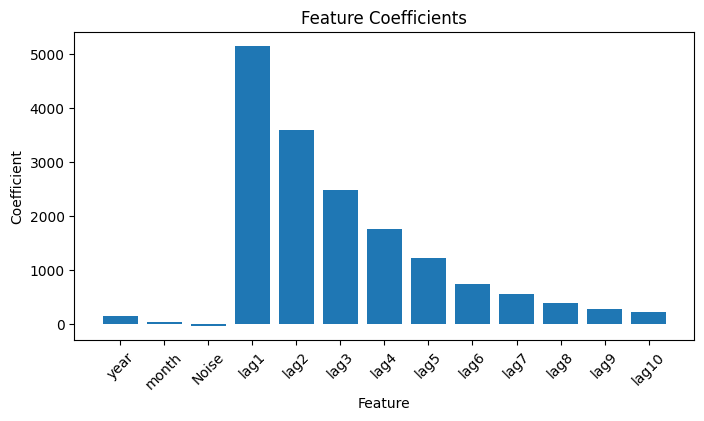

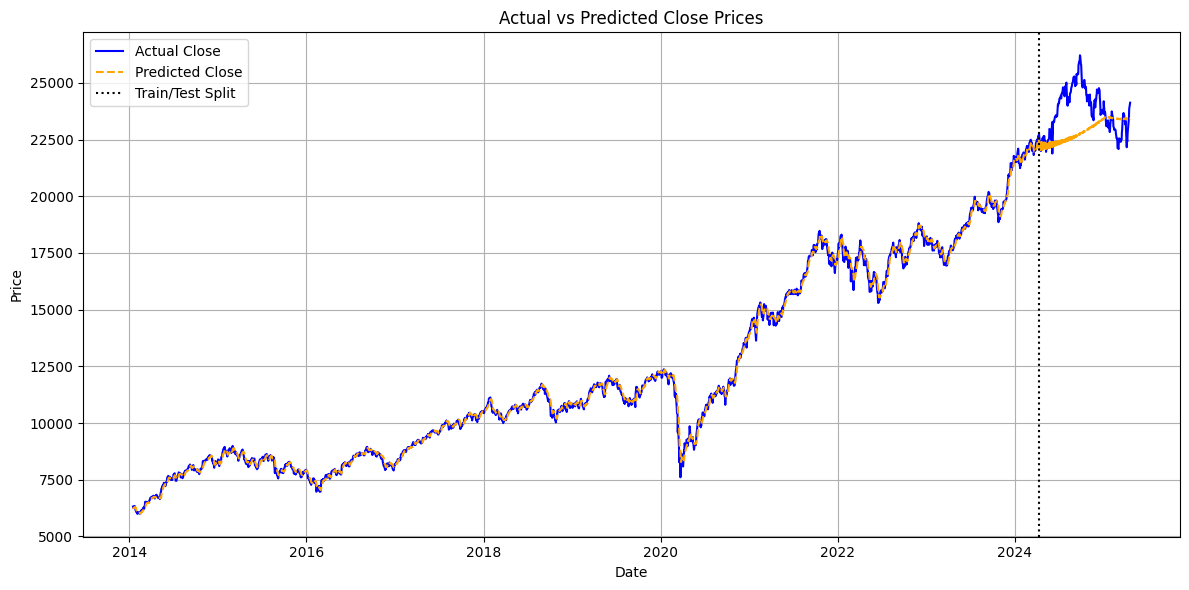

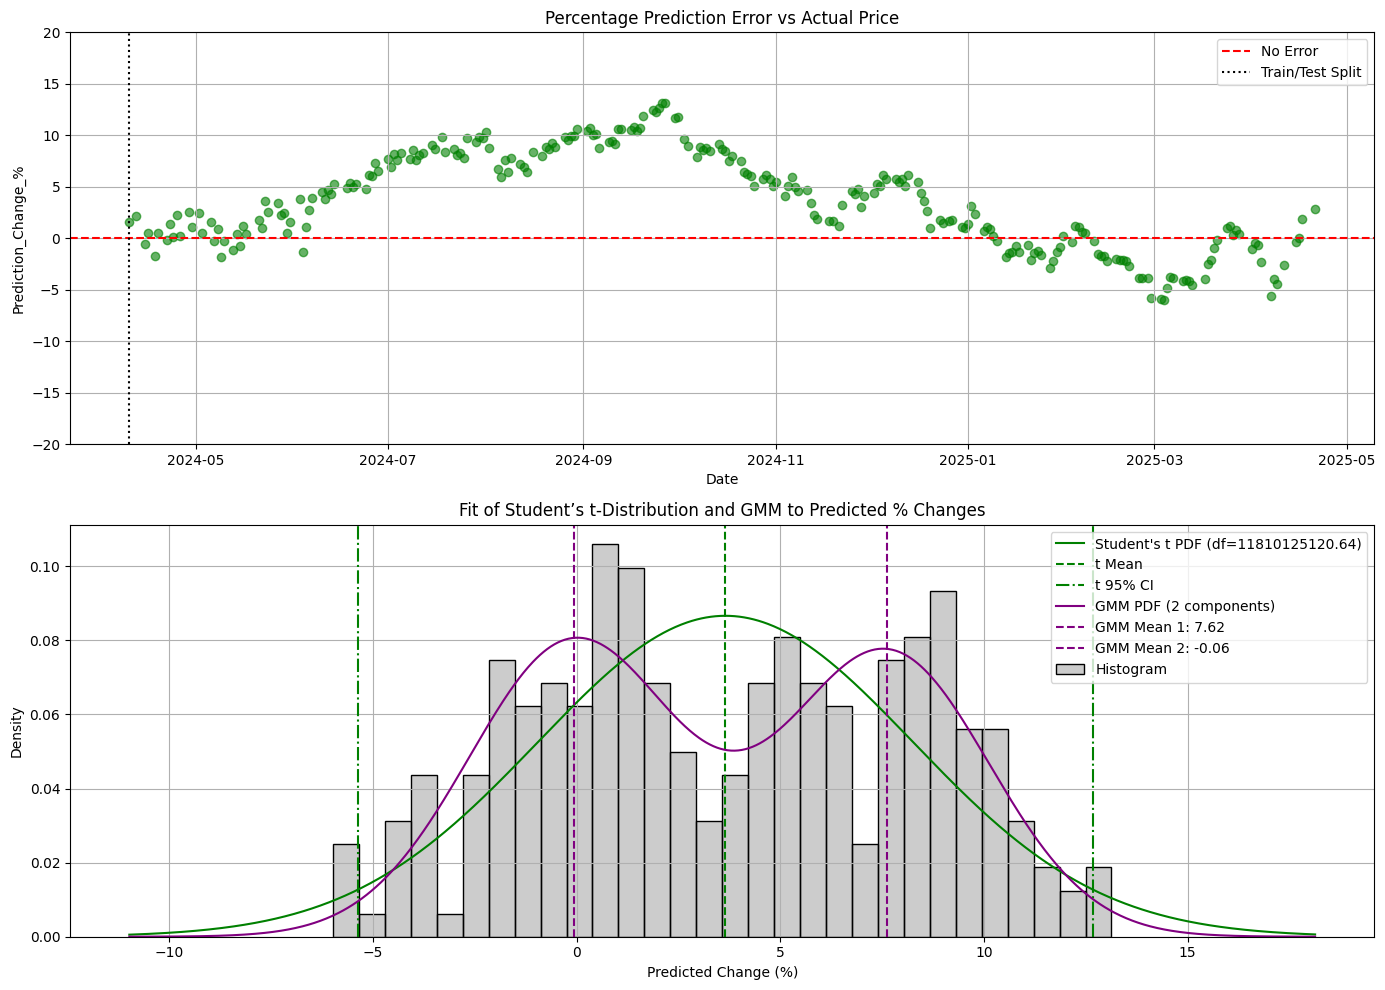

Student's t-distribution 95% CI: [-5.37, 12.68]
GMM means: [ 7.62198954 -0.05700606], std devs: [2.51180505 2.57826877]


In [ ]:
ml_models = ['RidgeModel', 'RandomForestModel', 'SimpleNNModel','LSTMModel']
predictor.run_ml(npast=10, model_type=ml_models[0])

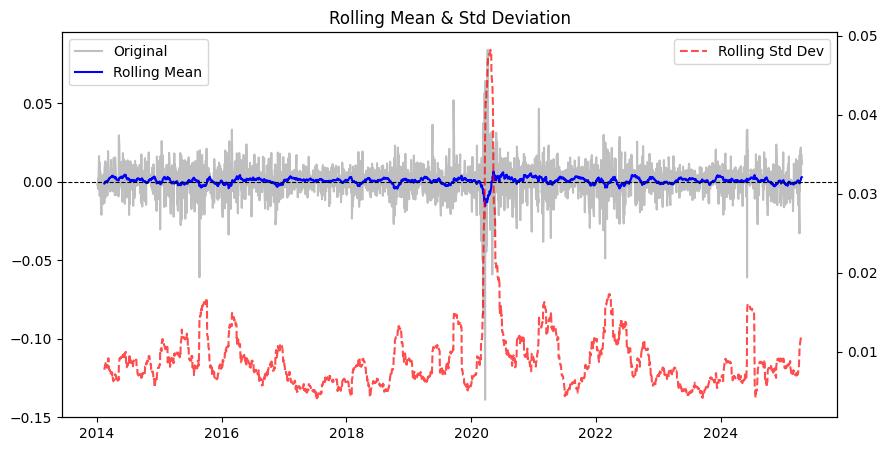

ADF Test
ADF Statistic: -14.5700, p-value: 0.0000
Stationary
KPSS Test
KPSS Statistic: 0.0321, p-value: 0.1000
Stationary


<ipython-input-159-eed9b7579bcd>:176: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, crit = kpss(self.series.dropna(), regression='c')


<Figure size 1200x500 with 0 Axes>

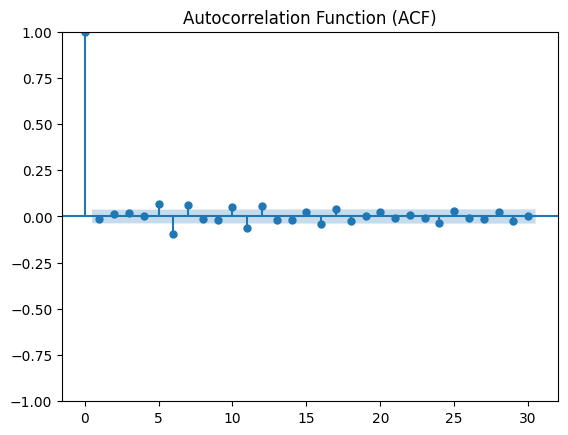

<Figure size 1200x500 with 0 Axes>

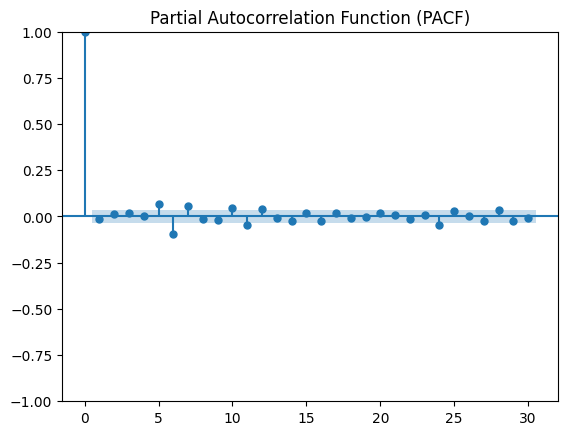

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 2519
Model:             SARIMAX(10, 0, 0)x(1, 0, 0, 12)   Log Likelihood                7955.859
Date:                             Tue, 22 Apr 2025   AIC                         -15887.717
Time:                                     10:46:41   BIC                         -15817.738
Sample:                                          0   HQIC                        -15862.321
                                            - 2519                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0111      0.013      0.852      0.394      -0.014       0.037
ar.L2          0.0016      

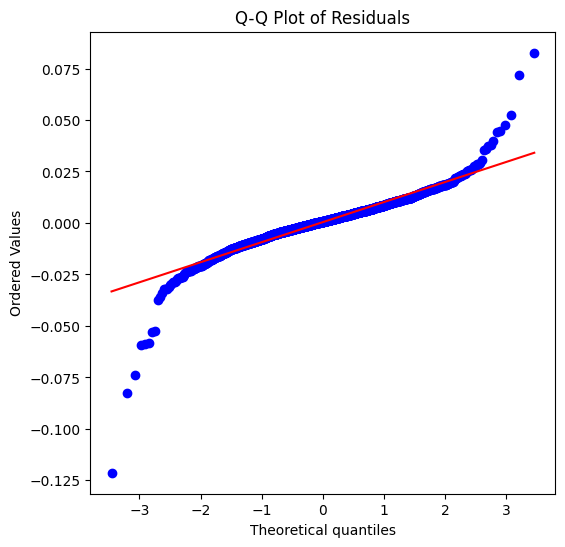

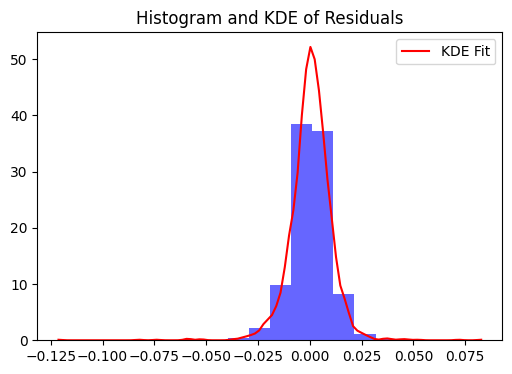

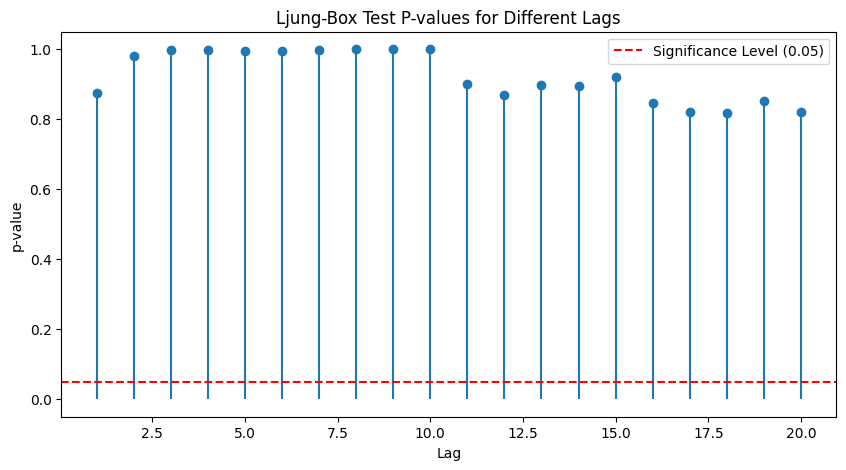

MAE: 0.0071
MSE: 0.0001
RMSE: 0.0103


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


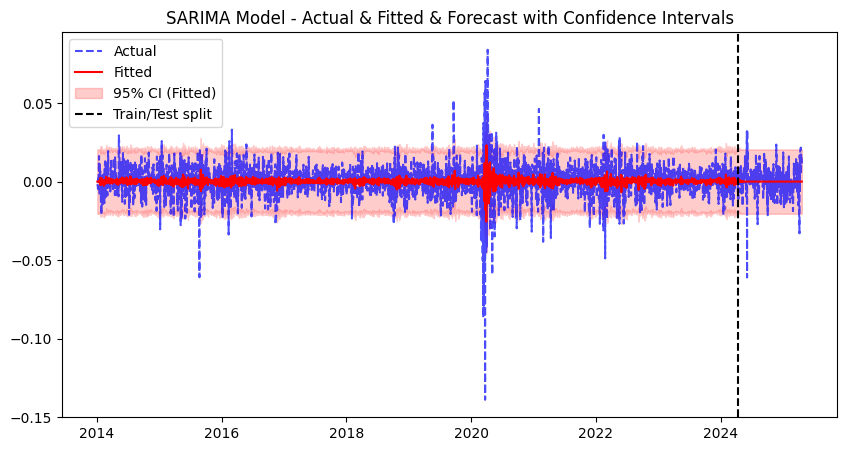

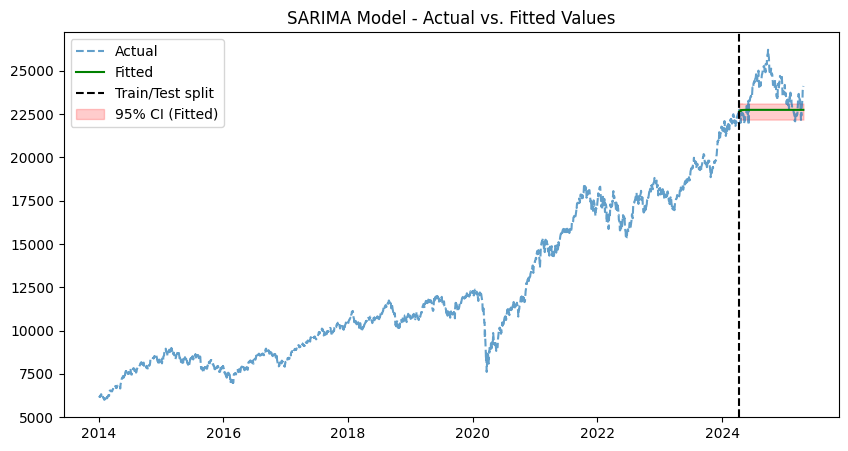

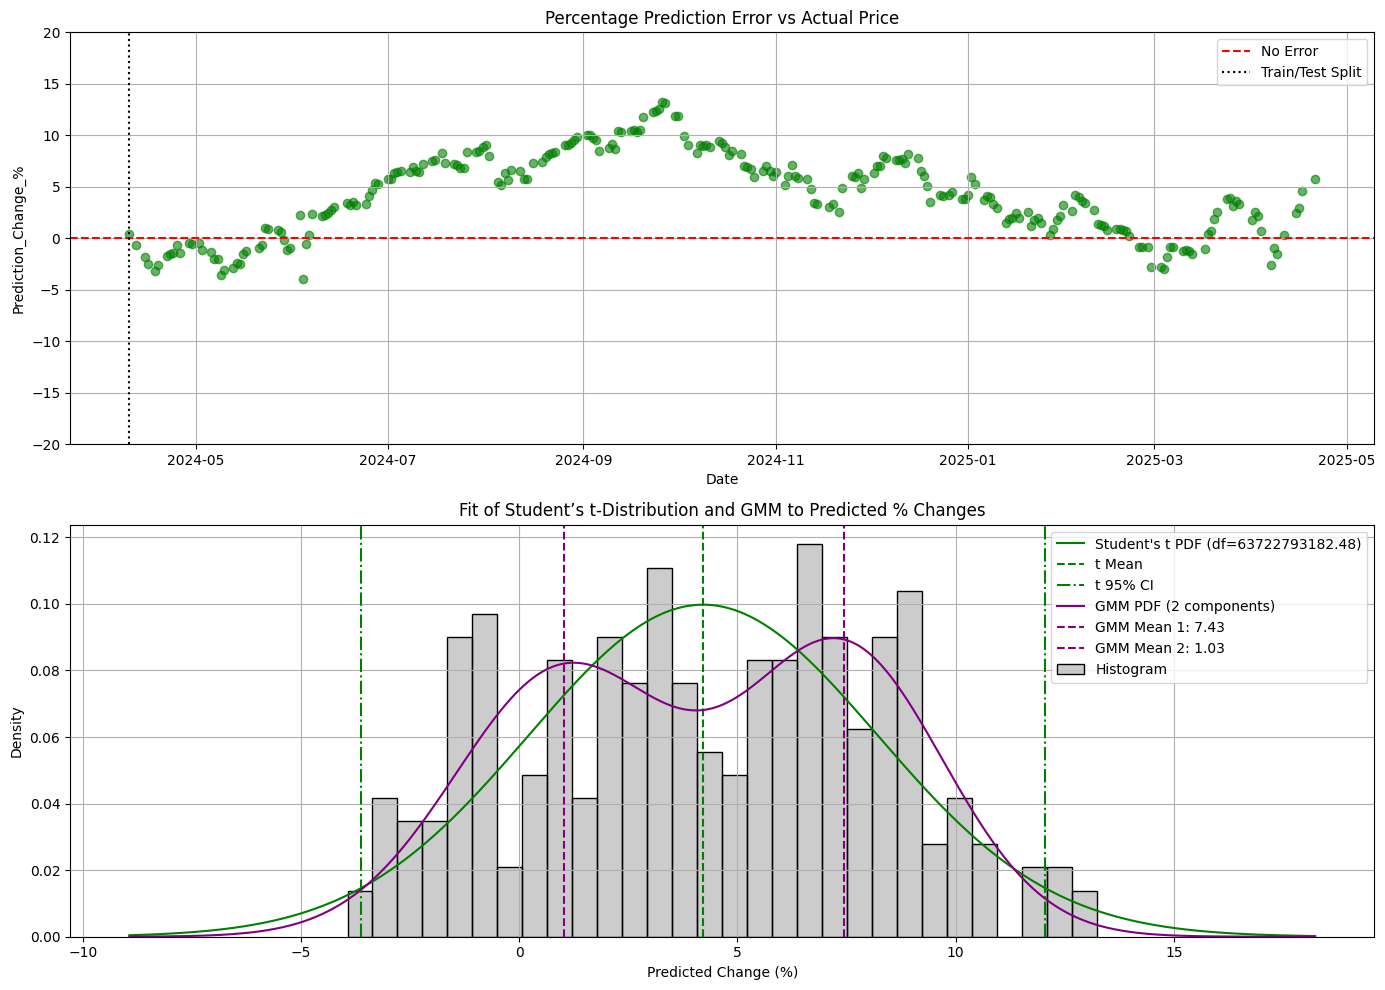

Student's t-distribution 95% CI: [-3.63, 12.05]
GMM means: [7.43069157 1.03375569], std devs: [2.29715668 2.49893742]


In [ ]:
ts_models = ['SARIMAModel']
npast=10
predictor.run_ts(order=(npast,0,0), seasonal_order=(1,0,0,12), model_type=ts_models[0])